In [1]:
import pandas as pd
from datetime import datetime
import numpy
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from collections import Counter
import re

In [2]:
def make_a_panda():
    #################### Path Locations of all CSV files #####################
    csvForbes = 'Ripple_Forbes.csv'
    csvCNBC = 'Ripple_CNBC.csv'
    csvCointelegraph = 'Ripple_Cointelegraph.csv'
    csvCoindesk = 'Ripple_Coindesk.csv'
    csvBitcoin = 'Ripple_Bitcoin.csv'
    
    #################### Make Pandas DataFrames ##########################
    dfForbes = pd.read_csv(csvForbes, encoding = 'utf-8', parse_dates = True)
    dfCNBC = pd.read_csv(csvCNBC, encoding = 'utf-8', parse_dates = True)
    dfCointelegraph = pd.read_csv(csvCointelegraph, encoding = 'utf-8', parse_dates = True)
    dfCoindesk = pd.read_csv(csvCoindesk, encoding = 'utf-8', parse_dates = True)
    dfBitcoin = pd.read_csv(csvBitcoin, encoding = 'utf-8', parse_dates = True)
    
    #Make a list of the DataFrames
    site = [dfForbes, dfCNBC, dfCointelegraph,dfCoindesk,dfBitcoin]
    
    #Concat the DataFrames into one
    df = pd.concat(site).reset_index()
    df.Date = pd.to_datetime(df.Date)
    df.set_index('Date', inplace = True)
    
    # Replace \xa0 non-breaking space in Latin1 (ISO 8859-1) with unicode space u' ' in the Text column
    df.Text = df.Text.apply(lambda x: x.replace(u'\xa0', u' '))
    
    
    #DataFrame of Ripple Pricing Data
    df2 = pd.read_csv('C:\\Users\\simskel\\Desktop\\Springboard-Data-Science-Immersive\\Capstone 1 Project\\Data\\XRP USD Poloniex Historical Data.csv', parse_dates = True)
    #Convert string dates to datetime dates
    df2.Date = pd.to_datetime(df2.Date)
    #remove the last 2 rows of the dataframe - Junk data
    df2 = df2.iloc[:-2]
    #Set Date column as Index
    df2.set_index('Date', inplace = True)
    #Sort the index
    df2 = df2.sort_index(ascending = True)
    #convert columns from string to type Float
    df2[['Price','High','Low','Change %']] = df2[['Price','High','Low','Change %']].applymap(lambda x: float(x))
    
    return df, df2

** One of the challenges of NLP is breaking up a body of text into its individual sentences. Usually when scraped text is read in, it is read in as 1 string. e.g. **

>  *MyString* = **"** *Four score and seven years ago our fathers brought forth, upon this continent, a new nation, conceived in Liberty, and dedicated to the proposition that all men are created equal. Now we are engaged in a great civil war, testing whether that nation, or any nation so conceived, and so dedicated, can long endure. We are met on a great battle-field of that war. We have come to dedicate a portion of that field, as a final resting-place for those who here gave their lives, that that nation might live. It is altogether fitting and proper that we should do this. But, in a larger sense, we can not dedicate, we can not consecrate we can not hallow this ground. The brave men, living and dead, who struggled here, have consecrated it far above our poor power to add or detract. The world will little note, nor long remember what we say here, but it can never forget what they did here. It is for us, the living, rather, to be dedicated here to the unfinished work which they who fought here, have, thus far, so nobly advanced. It is rather for us to be here dedicated to the great task remaining before us that from these honored dead we take increased devotion to that cause for which they here gave the last full measure of devotion that we here highly resolve that these dead shall not have died in vain that this nation, under God, shall have a new birth of freedom and that government of the people, by the people, for the people, shall not perish from the earth.* **"**

** There's multiple instances of periods in this text string, but we can't always trust that all periods in a body of text are being used as sentence terminators. Conversely, periods aren't the only punctuation used to terminate sentences. Question marks and exclamation marks are also used. Therefore, we need a classifier to determine when a period (.) exclamation point (!) or quesiton mark (?) is being used as a sentence terminator or as something else. **

In [14]:
import nltk
def sentence_trainer(sentences = nltk.corpus.treebank_raw.sents()):
    
    '''This function serves as a classification trainer for sentence segmentation. Based on text input, the classifier trained in
    this function will determine if a given punctuation mark terminates the preceding sentence. From its classification,
    multiple sentences, as one string, can be segmented into it's individual sentences'''
    
    #INPUT -> Corpus that has already been segmented into sentences (NLTK corpus treebank_raw is used as default input)
    #OUPUT -> Trained classifier that determines if punctuation marks are sentence terminators

    #Tokens is a merged list of tokens from the individual sentences including punctuation
    tokens = []
    #Boundaries is a set containing the indices of all sentence-boundary tokens
    boundaries = set()
    offset = 0
    for sent in sentences:
        tokens.extend(sent)
        offset += len(sent)
        boundaries.add(offset-1)

    #Extract features of all instances of punctuation in the "tokens" list. Features are:
    #Is the word following the puncatuation mark capitalized:                            True or False
    #Is the previous word of the punctuation mark all lower case:                        True or False
    #What is the punctuation:                                                            ['.' , '?' , '!']
    #Is the previous word of the punctuation mark one character:                         True or False
    def punct_features(tokens, i):
        return {'next-word-capitalized': tokens[i+1][0].isupper(),
                 'prevword': tokens[i-1].lower(),
                 'punct': tokens[i],
                 'prev_word_is_one_char': len(tokens[i-1]) == 1}
    #create a features set of all instances of punctuation
    featuresets = [(punct_features(tokens,i), (i in boundaries)) for i in range(1,len(tokens)-1) if tokens[i] in '.?!']
    
    #Example Featureset:
    '''({'next-word-capitalized': False, 'prevword': 'nov', 'punct': '.', 'prev_word_is_one_char': False}, False)
       ({'next-word-capitalized': True, 'prevword': '29', 'punct': '.', 'prev_word_is_one_char': False}, True)
       ({'next-word-capitalized': True, 'prevword': 'mr', 'punct': '.', 'prev_word_is_one_char': False}, False)
       ({'next-word-capitalized': True, 'prevword': 'n', 'punct': '.', 'prev_word_is_one_char': True}, False)'''
    #True-False as the second item in the tuple is if the punct of interest was contained in the boundaries set

    #Use 90% of data as training set and 10% as test set
    size = int(len(featuresets)*0.1)
    train_set, test_set = featuresets[size:], featuresets[:size]
    #Train Classifier
    classifier = nltk.NaiveBayesClassifier.train(train_set)
    accuracy = nltk.classify.accuracy(classifier, test_set)
    return classifier , punct_features

** Getting an accurate sentiment analysis rating of the articles will be key to properly predicting cryptocurrency based on articles. There are already some "out of the box" libraries that can be utilized in performing this analysis. But also a custom sentiment analyzer might be needed in the event these OOTB analyzers don't perform very well. In order to facilitate this trial and error test of each SA method, the following class has been created to facilitate efforts**

In [264]:
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt

class sentiment_analysis:
    
    def __init__(self,text,headline = False):
        #INPUT -> Article Headline
        if headline is True:
            self.text = text
        #INPUT -> List of Sentences
        elif isinstance(text,list):
            self.sentences = text
        #INPUT -> String of Sentences
        else:
            self.text = text[:-1]

        
    def remove_stopwords(self, remove_punc = False):
        #INPUT -> string of sentences or headline
        #OUTPUT -> string of sentences or headline with stopwords and/or punctuation removed
        if hasattr(self, 'text'):
            #if user wants punctuation removed in conjuction with removing stop words
            if remove_punc == True:
                self.remove_punctuation = [char for char in self.text if char not in string.punctuation]
                self.no_punctuation = ''.join(self.remove_punctuation)
                self.no_stopwords = [word for word in self.no_punctuation.split() if word.lower() not in stopwords.words('english')]
                return sentiment_analysis(' '.join(self.no_stopwords))
            #if user only wants to remove stop words
            else:
                word = nltk.word_tokenize(self.text)
                self.no_stopwords = [word for word in word if word.lower() not in stopwords.words('english')]
                return sentiment_analysis(' '.join(self.no_stopwords))
            
        #INPUT -> list of sentences
        #OUTPUT -> list of sentences with stopwords and/or punctuation removed
        else:
            self.list_no_stopwords = []
            #if user wants punctuation removed in conjuction with removing stop words
            if remove_punc == True:
                for sentence in self.sentences:
                    self.remove_punctuation = [char for char in sentence if char not in string.punctuation]
                    self.no_punctuation = ''.join(self.remove_punctuation)
                    self.no_stopwords = [word for word in self.no_punctuation.split() if word.lower() not in stopwords.words('english')]
                    self.list_no_stopwords.append(' '.join(self.no_stopwords))
                return sentiment_analysis(self.list_no_stopwords)
            #if user only wants to rmove stop words
            else:
                for sentence in self.sentences:
                    word = nltk.word_tokenize(sentence)
                    self.no_stopwords = [word for word in word if word.lower() not in stopwords.words('english')]
                    self.list_no_stopwords.append(' '.join(self.no_stopwords))
                return sentiment_analysis(self.list_no_stopwords)
            
            
    #INPUT -> String of Sentences
    #OUTPUT -> List of Sentences From the Single String of Sentences Using the Sentence Classifier: sentence_trainer()
    def segment_sentences(self):
        '''In order to seperate a string of sentences into a list of its individual sentences, the classifier relies on all the
        punctuation in the text and the features of said punctuation in order to determine if a particular punctuation mark
        terminates  a sentence. Because of this, punctuation must exist within the text string.'''
        #check for punctuation in the text
        check_for_punctuation = re.findall(r'[.?!]',self.text)
        #if no punctuation exists
        if not check_for_punctuation:
            print('Sentence segmentation requires punctuation','\n',
                  'You must have used the remove_stopwords() method with arguement set as True','\n',
                  'Leave arguement for remove_stopwords() method as the default, False if you plan to use this method.')
        else:
            #tokenize the text
            self.tokens = word_tokenize(self.text)
            #unpack the trained classifier and its features extractor to use on the unclassified data
            #see "sentence_trainer()" documentation for more information
            sentence_classifier, extract_features = sentence_trainer()
            start = 0
            self.sentences = []
            for i, word in enumerate(self.tokens):
                #check if the current token is one of the punctuations in .?! AND the classifier has classified the punctuation
                #as a sentence terminator, i.e. the classifier returns 'True' 
                if word in '.?!' and sentence_classifier.classify(extract_features(self.tokens,i)) == True:
                    #append all tokens before the current punctuation (the sentence) to the list
                    self.sentences.append(self.tokens[start:i+1])
                    start = i+1
            if start < len(self.tokens):
                #append the last sentence to the list
                self.sentences.append(self.tokens[start:])
                self.list_of_sentences = [' '.join(sent) for sent in self.sentences]
            return sentiment_analysis(self.list_of_sentences)
    
   
    def darth_vader(self):
        #INPUT -> list of sentences
        #OUPUT -> vader sentiment analysis for each sentence in the list
        try:
            sid = SentimentIntensityAnalyzer()
            self.vader_scores = [sid.polarity_scores(sentence) for sentence in self.sentences]
            return self.vader_scores
        #INPUT -> sentence string
        #OUTPUT -> vader sentiment analysis for the string
        except:
            sid = SentimentIntensityAnalyzer()
            self.vader_score = sid.polarity_scores(self.text)
            return self.vader_score
            
            
            
    def blobbed(self):
        #INPUT -> list of sentences
        #OUPUT -> TextBlob sentiment analysis for each sentence in the list
        try:
            blobbed_sentences = [TextBlob(sentence) for sentence in self.sentences]
            self.blob_scores = [sentence.sentiment for sentence in blobbed_sentences]
            return self.blob_scores
        #INPUT -> sentence string
        #OUTPUT -> TextBlob sentiment analysis for the string
        except:
            blobbed_headline = TextBlob(self.text)
            self.blob_score = blobbed_headline.sentiment
            return self.blob_score
            
            
            
    #INPUT -> string of sentences or a single sentence
    #OUTPUT -> word cloud composed of words from the string input
    def word_cloud(self):
        wordcloud = WordCloud(background_color = 'white',
                              max_words = 200,
                              max_font_size = 40,
                             scale = 3,
                             random_state = 1).generate(self.text)
        fig = plt.figure(figsize=(15,15))
        self.ax = plt.imshow(wordcloud)
        plt.axis('off')
        plt.show()
        return self.ax


In [265]:
df, df2 = make_a_panda()

In [266]:
df.columns

Index(['index', 'Coin', 'website', 'Headline', 'Text', 'Link'], dtype='object')

### Sample an article text to be analyzed

In [267]:
df.Text[0]

'GERMANY, BONN - JANUARY 31: Symbol photo on the topics crypto currency, digital currency, currency speculation, course gains, course losses, money laundering, crime. etc. The picture shows Ripple coins and a Bitcoin (physical). (Photo by Ulrich Baumgarten via Getty Images) Ripple solidifies #3 cryptocurrency spot with a $35.7B market cap. [Ed note: Investing in cryptocoins or tokens is highly speculative and the market is largely unregulated. Anyone considering it should be prepared to lose their entire investment.] After a general trend of consolidation in the worldwide cryptocurrency market—following drops in the Dow Jones industrial average, Facebook banning cryptocurrency advertising, news of Chinese and South Korean regulation, India pushing toward a crackdown and news of Tether and Bitfinex subpoenas—the market cap is beginning to inch back up after January\'s lows. One coin in particular made big leaps overnight (PST): Ripple (XRP). Disclosure: I own some Ripple.  According to 

### Create a sentiment_analysis object with the sampled text

In [268]:
text = df.Text[0]
analyzed_text = sentiment_analysis(text)

### The original text can be seen with the .text attribute after creating the object

In [269]:
analyzed_text.text

'GERMANY, BONN - JANUARY 31: Symbol photo on the topics crypto currency, digital currency, currency speculation, course gains, course losses, money laundering, crime. etc. The picture shows Ripple coins and a Bitcoin (physical). (Photo by Ulrich Baumgarten via Getty Images) Ripple solidifies #3 cryptocurrency spot with a $35.7B market cap. [Ed note: Investing in cryptocoins or tokens is highly speculative and the market is largely unregulated. Anyone considering it should be prepared to lose their entire investment.] After a general trend of consolidation in the worldwide cryptocurrency market—following drops in the Dow Jones industrial average, Facebook banning cryptocurrency advertising, news of Chinese and South Korean regulation, India pushing toward a crackdown and news of Tether and Bitfinex subpoenas—the market cap is beginning to inch back up after January\'s lows. One coin in particular made big leaps overnight (PST): Ripple (XRP). Disclosure: I own some Ripple.  According to 

### The stop words can be removed from the text via .remove_stopwords() method
##### This method returns another sentiment_analysis() object and the new text with removed stop words can be seen with the .text attribute

In [270]:
analyzed_text.remove_stopwords().text

"GERMANY , BONN - JANUARY 31 : Symbol photo topics crypto currency , digital currency , currency speculation , course gains , course losses , money laundering , crime . etc . picture shows Ripple coins Bitcoin ( physical ) . ( Photo Ulrich Baumgarten via Getty Images ) Ripple solidifies # 3 cryptocurrency spot $ 35.7B market cap . [ Ed note : Investing cryptocoins tokens highly speculative market largely unregulated . Anyone considering prepared lose entire investment . ] general trend consolidation worldwide cryptocurrency market—following drops Dow Jones industrial average , Facebook banning cryptocurrency advertising , news Chinese South Korean regulation , India pushing toward crackdown news Tether Bitfinex subpoenas—the market cap beginning inch back January 's lows . One coin particular made big leaps overnight ( PST ) : Ripple ( XRP ) . Disclosure : Ripple . According CoinMarketCap , Ripple trading $ 0.771540 USD 9:19pm PST Feb. 8 . 6:44am Feb. 9 , number $ 0.931411—a jump 21 pe

### All punctuation characters can be removed as well by setting the remove_punc arguement to True in the remove_stopwords() method

In [271]:
analyzed_text.remove_stopwords(remove_punc = True).text

'GERMANY BONN JANUARY 31 Symbol photo topics crypto currency digital currency currency speculation course gains course losses money laundering crime etc picture shows Ripple coins Bitcoin physical Photo Ulrich Baumgarten via Getty Images Ripple solidifies 3 cryptocurrency spot 357B market cap Ed note Investing cryptocoins tokens highly speculative market largely unregulated Anyone considering prepared lose entire investment general trend consolidation worldwide cryptocurrency market—following drops Dow Jones industrial average Facebook banning cryptocurrency advertising news Chinese South Korean regulation India pushing toward crackdown news Tether Bitfinex subpoenas—the market cap beginning inch back Januarys lows One coin particular made big leaps overnight PST Ripple XRP Disclosure Ripple According CoinMarketCap Ripple trading 0771540 USD 919pm PST Feb 8 644am Feb 9 number 0931411—a jump 21 percent 10 hours Ripple 24hour trading chart price currently 0916888 21 percent higher day ag

### The single text sting can be broken into a list of its individual sentences in order to perform sentiment analysis on each individual sentence by using the .segment_sentences() method

#### This method returns another sentiment_analysis() object and the list of sentences can be viewed by using the .sentences attribute

In [272]:
analyzed_text.segment_sentences().sentences

['GERMANY , BONN - JANUARY 31 : Symbol photo on the topics crypto currency , digital currency , currency speculation , course gains , course losses , money laundering , crime .',
 'etc .',
 'The picture shows Ripple coins and a Bitcoin ( physical ) . ( Photo by Ulrich Baumgarten via Getty Images ) Ripple solidifies # 3 cryptocurrency spot with a $ 35.7B market cap . [ Ed note : Investing in cryptocoins or tokens is highly speculative and the market is largely unregulated .',
 'Anyone considering it should be prepared to lose their entire investment .',
 "] After a general trend of consolidation in the worldwide cryptocurrency market—following drops in the Dow Jones industrial average , Facebook banning cryptocurrency advertising , news of Chinese and South Korean regulation , India pushing toward a crackdown and news of Tether and Bitfinex subpoenas—the market cap is beginning to inch back up after January 's lows .",
 'One coin in particular made big leaps overnight ( PST ) : Ripple (

### The stop words can be removed before segmenting into sentences
#### NOTE: if removing stopwords before segmenting sentences, punctuation CAN NOT be removed due to the fact that the sentence segmentation uses punctuation in order to determine where the sentences should be split

In [273]:
analyzed_text.remove_stopwords().segment_sentences().sentences

['GERMANY , BONN - JANUARY 31 : Symbol photo topics crypto currency , digital currency , currency speculation , course gains , course losses , money laundering , crime .',
 'etc .',
 'picture shows Ripple coins Bitcoin ( physical ) . ( Photo Ulrich Baumgarten via Getty Images ) Ripple solidifies # 3 cryptocurrency spot $ 35.7B market cap . [ Ed note : Investing cryptocoins tokens highly speculative market largely unregulated .',
 'Anyone considering prepared lose entire investment .',
 "] general trend consolidation worldwide cryptocurrency market—following drops Dow Jones industrial average , Facebook banning cryptocurrency advertising , news Chinese South Korean regulation , India pushing toward crackdown news Tether Bitfinex subpoenas—the market cap beginning inch back January 's lows .",
 'One coin particular made big leaps overnight ( PST ) : Ripple ( XRP ) . Disclosure : Ripple .',
 'According CoinMarketCap , Ripple trading $ 0.771540 USD 9:19pm PST Feb. 8 . 6:44am Feb. 9 , numbe

### Vader Sentiment Analysis can be performed on the whole text string 

In [274]:
analyzed_text.darth_vader()

{'compound': 0.8849, 'neg': 0.036, 'neu': 0.896, 'pos': 0.068}

### Vader Sentiment Analysis can be performed on the whole text string after removing stop words

In [275]:
analyzed_text.remove_stopwords().darth_vader()

{'compound': 0.9299, 'neg': 0.044, 'neu': 0.852, 'pos': 0.104}

### Vader Sentiment Analysis can be performed on whole text string  after removing stop words and punctuation

In [276]:
analyzed_text.remove_stopwords(True).darth_vader()

{'compound': 0.9299, 'neg': 0.044, 'neu': 0.85, 'pos': 0.106}

### Vader Sentiment Analysis can be performed on each individual sentence in the text

In [277]:
analyzed_text.segment_sentences().darth_vader()

[{'compound': -0.5859, 'neg': 0.225, 'neu': 0.688, 'pos': 0.087},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.1761, 'neg': 0.0, 'neu': 0.957, 'pos': 0.043},
 {'compound': -0.2023, 'neg': 0.199, 'neu': 0.662, 'pos': 0.14},
 {'compound': -0.2023, 'neg': 0.035, 'neu': 0.965, 'pos': 0.0},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.0772, 'neg': 0.0, 'neu': 0.956, 'pos': 0.044},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.3818, 'neg': 0.0, 'neu': 0.938, 'pos': 0.062},
 {'compound': 0.2732, 'neg': 0.0, 'neu': 0.935, 'pos': 0.065},
 {'compound': 0.5859, 'neg': 0.0, 'neu': 0.849, 'pos': 0.151},
 {'compound': 0.5106, 'neg': 0.0, 'neu': 0.895, 'pos': 0.105},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': -0.3261, 'neg': 0.173, 'neu': 0.752, 'pos': 0.075},
 {'compound': 0.2732, 'neg': 0.0, 'neu': 0.877, 'pos': 0.123},
 {'compound': 0.6369, 'neg': 0.0, 'neu': 0.861, 'pos': 0.139}]

### Vader Sentiment Analysis can be performed on each individual sentence with stop words removed

In [278]:
analyzed_text.segment_sentences().remove_stopwords().darth_vader()

[{'compound': -0.5859, 'neg': 0.242, 'neu': 0.664, 'pos': 0.094},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.1761, 'neg': 0.0, 'neu': 0.943, 'pos': 0.057},
 {'compound': -0.2023, 'neg': 0.314, 'neu': 0.465, 'pos': 0.221},
 {'compound': -0.2023, 'neg': 0.049, 'neu': 0.951, 'pos': 0.0},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.0772, 'neg': 0.0, 'neu': 0.929, 'pos': 0.071},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.3818, 'neg': 0.0, 'neu': 0.906, 'pos': 0.094},
 {'compound': 0.2732, 'neg': 0.0, 'neu': 0.913, 'pos': 0.087},
 {'compound': 0.5859, 'neg': 0.0, 'neu': 0.78, 'pos': 0.22},
 {'compound': 0.5106, 'neg': 0.0, 'neu': 0.845, 'pos': 0.155},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.2732, 'neg': 0.137, 'neu': 0.588, 'pos': 0.275},
 {'compound': 0.2732, 'neg': 0.0, 'neu': 0.792, 'pos': 0.208},
 {'compound': 0.6369, 'neg': 0.0, 'neu': 0.811, 'pos': 0.189}]

### TextBlob Sentiment Analysis can be performed on the text string in the same ways as Vader Sentiment

In [279]:
analyzed_text.blobbed()

Sentiment(polarity=0.13159663865546214, subjectivity=0.39641456582633056)

In [280]:
analyzed_text.remove_stopwords().blobbed()

Sentiment(polarity=0.11330952380952382, subjectivity=0.353436507936508)

In [281]:
analyzed_text.remove_stopwords(True).blobbed()

Sentiment(polarity=0.11330952380952382, subjectivity=0.353436507936508)

In [282]:
analyzed_text.segment_sentences().blobbed()

[Sentiment(polarity=0.0, subjectivity=0.0),
 Sentiment(polarity=0.0, subjectivity=0.0),
 Sentiment(polarity=0.12476190476190475, subjectivity=0.37047619047619046),
 Sentiment(polarity=0.0, subjectivity=0.625),
 Sentiment(polarity=-0.024999999999999994, subjectivity=0.22499999999999998),
 Sentiment(polarity=0.25555555555555554, subjectivity=0.4777777777777778),
 Sentiment(polarity=0.0, subjectivity=0.0),
 Sentiment(polarity=0.125, subjectivity=0.45),
 Sentiment(polarity=0.14166666666666666, subjectivity=0.5458333333333333),
 Sentiment(polarity=0.0, subjectivity=0.375),
 Sentiment(polarity=0.0, subjectivity=0.0),
 Sentiment(polarity=0.09583333333333333, subjectivity=0.3833333333333333),
 Sentiment(polarity=0.0, subjectivity=0.0),
 Sentiment(polarity=0.375, subjectivity=0.875),
 Sentiment(polarity=0.15833333333333333, subjectivity=0.4583333333333333),
 Sentiment(polarity=0.3666666666666667, subjectivity=0.2333333333333333)]

In [283]:
analyzed_text.segment_sentences().remove_stopwords().blobbed()

[Sentiment(polarity=0.0, subjectivity=0.0),
 Sentiment(polarity=0.0, subjectivity=0.0),
 Sentiment(polarity=0.12476190476190475, subjectivity=0.37047619047619046),
 Sentiment(polarity=0.0, subjectivity=0.625),
 Sentiment(polarity=-0.024999999999999994, subjectivity=0.22499999999999998),
 Sentiment(polarity=0.08333333333333333, subjectivity=0.21666666666666667),
 Sentiment(polarity=0.0, subjectivity=0.0),
 Sentiment(polarity=0.125, subjectivity=0.45),
 Sentiment(polarity=0.24375, subjectivity=0.6),
 Sentiment(polarity=0.0, subjectivity=0.375),
 Sentiment(polarity=0.0, subjectivity=0.0),
 Sentiment(polarity=0.09583333333333333, subjectivity=0.3833333333333333),
 Sentiment(polarity=0.0, subjectivity=0.0),
 Sentiment(polarity=0.375, subjectivity=0.875),
 Sentiment(polarity=-0.0625, subjectivity=0.1875),
 Sentiment(polarity=0.3666666666666667, subjectivity=0.2333333333333333)]

### A word cloud can be created from the text

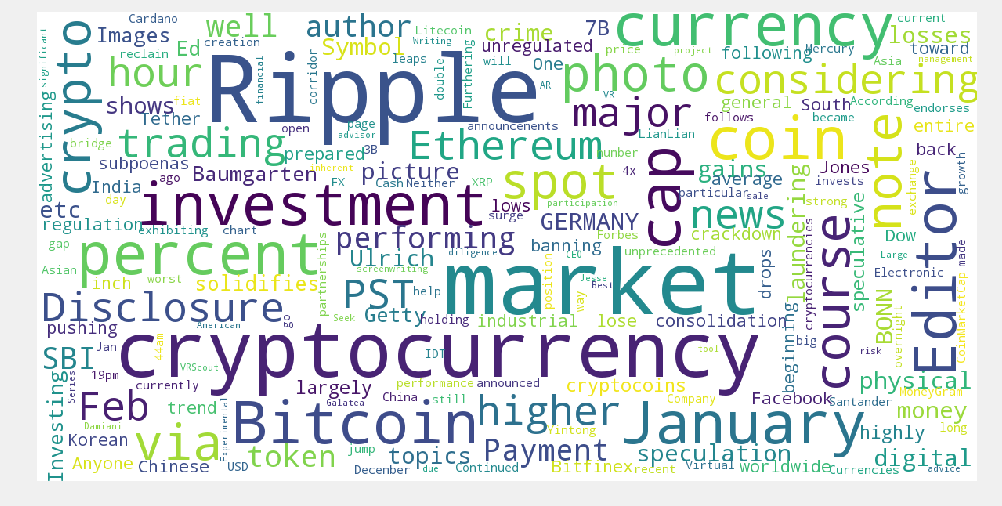

In [284]:
analyzed_text.word_cloud()

### Headlines of articles can be analyzed in the same fashion as the text of articles

In [285]:
headline = df.Headline[0]
analyzed_headline = sentiment_analysis(headline, headline = True)

In [286]:
analyzed_headline.text

'Crypto Watch: Ripple (XRP) Price Surges 21% in 10 Hours'

In [287]:
analyzed_headline.darth_vader()

{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}

In [291]:
analyzed_headline.remove_stopwords(True).text

'Crypto Watch Ripple XRP Price Surges 21 10 Hour'

In [288]:
analyzed_headline.blobbed()

Sentiment(polarity=0.0, subjectivity=0.0)

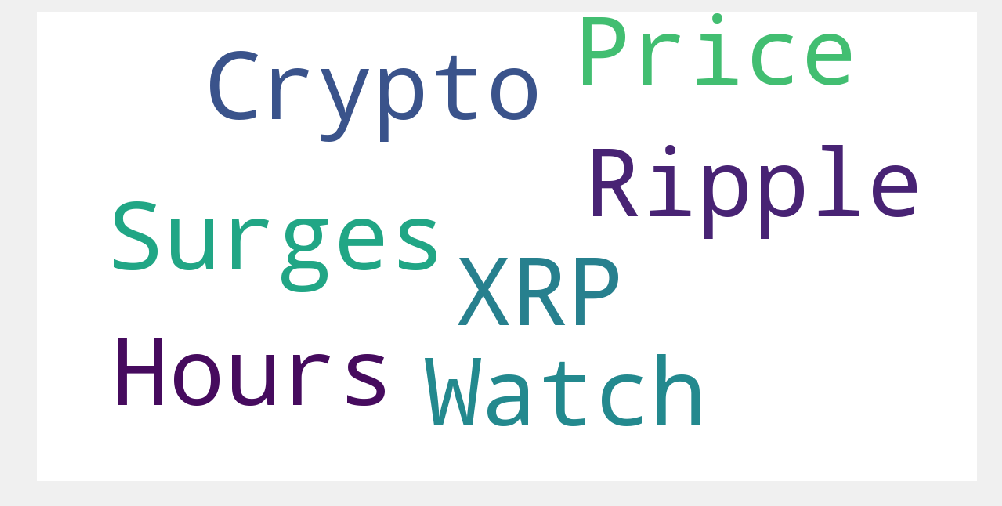

In [289]:
analyzed_headline.word_cloud()